In [2]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.integrate as sp
from scipy.interpolate import interp1d
import numdifftools as nd
from findiff import FinDiff

In [3]:
dates, times, flow = np.loadtxt('data/water.csv', unpack = True, usecols = (2, 3, 5), dtype=object)
flow = np.array(flow, dtype=float)
t = np.zeros(dates.size)
for i in range(dates.size):
    d = datetime.strptime(dates[i]+times[i], '%Y-%m-%d%H:%M')
    t[i] = d.timestamp()
start_time = t[0]
t -= start_time

In [21]:
def ys(val, xs=t, ys=flow):
    if len(val) == 1:
        idx = (np.abs(xs - val)).argmin()
        return ys[idx]
    else:
        ids = np.zeros(len(val), dtype=int)
        for i in range(len(val)):
            ids[i] = np.argmin(np.abs(xs - val[i])).astype(int)
        return ys[ids]

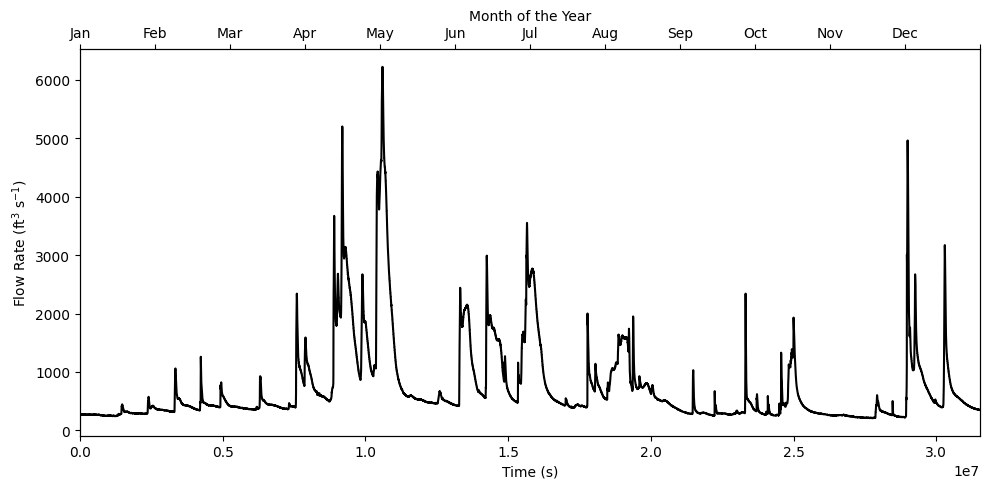

In [3]:
fig, ax = plt.subplots(figsize = (10,5))

ax.plot(t, flow, 'k')
# tdash = np.linspace(t[0], t[-1], 1000)
# ax.plot(tdash, f(tdash), 'r')
# ax.plot(t[1:], np.diff(flow), 'k')
# ax.plot(t[1:], np.diff(t), 'xk')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Flow Rate (ft$^3$ s$^{-1}$)')
# ax.set_ylim(0, 6400)
ax.set_xlim(0, t[-1])

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.linspace(0, t[-1], 13))
ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', ''])
ax2.set_xlabel('Month of the Year')
plt.tight_layout()
plt.savefig('plots/3/dams.png', dpi=200)

In [9]:
def d4dt(y,h=1):
    diffs = np.zeros(len(y))
    for x in range(2, len(y)-2):
        diffs[x] = (y[x+2]-4*y[x+1]+6*y[x]-4*y[x-1]+y[x-2])/h**4
    return diffs

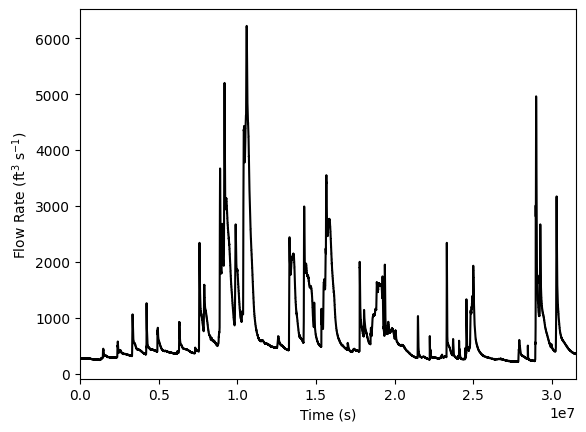

In [5]:
f1 = flow
t1 = t
plt.plot(t1, f1, '-k', alpha=1)
plt.xlabel('Time (s)')
plt.ylabel('Flow Rate (ft$^3$ s$^{-1}$)')
plt.xlim(t1[0], t1[-1])

t1 = (t1-np.min(t1))
t1 /= np.max(t1)

h = t1[1]-t1[0]
vmin = np.min(f1)
k = 1
half_step = (k*h)/2

n = len(t1)
dx = t1[1]-t[0]

## Mid-point rule

In [12]:
mid_point = 0
mid_point += f1[0]*half_step
for i in range(1,len(t1)-1,k):
    mid_point += f1[i]*half_step*2
mid_point += f1[-1]*half_step

def d2dt(y,h=1):
    diffs = np.zeros(len(y))
    for x in range(2, len(y)-2):
        diffs[x] = (y[x+1]+y[x-1]-2*y[x])/(h**2)
    return diffs

f2epsilon = np.max(abs(d2dt(f1)))
max_error_rectangle = ((t1[-1]-t[0]) * f2epsilon * dx**2)/(24)
mid_point

735.932687368038

## Trapezoidal

In [13]:
trapezoidal = (dx/2) * (f1[0] + 2*np.sum(f1[1:-1]) + f1[-1])
max_error_trapz = ((t1[-1]-t[0]) * f2epsilon * dx**2)/(12)

## Simpsons 1/3

In [14]:
""" simpsons 1/3 """
simpsons_13 = (dx/3) * (f1[0] + 4*np.sum(f1[1:n:2]) + 2*np.sum(f1[2:n-1:2]) + f1[-1])
f4epsilon = np.max(abs(d4dt(f1)))
max_error_simpsons = ((t1[-1]-t[0]) * f4epsilon * (dx**4))/(180)

## simpsons 3/8

In [15]:
""" simpsons 1/3 """
simpsons_38 = (3*dx/8) * (f1[0] + 3*(np.sum(f1[1:-1:3])+np.sum(f1[2:-1:3])) + 2*np.sum(f1[3:-1:3])+ f1[-1])
max_error_simpsons38 = ((t1[-1]-t1[0]) * f4epsilon * (dx**4))/(80)

## booles

In [18]:
boole = (2*dx/45) * (7*f1[0] + 32*np.sum(f1[1:-1:2]) + 12*np.sum(f1[2:-2:4]) + 14*np.sum(f1[4:-4:4])+ 7*f1[-1])
def d6dt(y,h=1):
    diffs = np.zeros(len(y))
    for x in range(3, len(y)-3):
        diffs[x] = (y[x-3]-6*y[x-2]+15*y[x-1]-20*y[x]+15*y[x+1]-6*y[x+2]+y[x+3])/(h**6)
    return diffs
f6epsilon = np.max(abs(d6dt(f1)))
max_error_boole = (2* (t1[-1]-t1[0]) * f6epsilon * (dx**6))/945

# Results

In [20]:
tmax = t[-1]
print(f'Mid-point: {mid_point*tmax*1e-9} x 10^9 ± {max_error_rectangle*tmax**4} ft^3')
print(f'Trapezoidal: {trapezoidal*tmax*1e-9} x 10^9 ± {max_error_trapz*tmax} ft^3')
print(f'Simpsons 1/3: {simpsons_13*tmax*1e-9} x 10^9 ± {max_error_simpsons*tmax**4} ft^3')
print(f'Simpsons 3/8: {simpsons_38*tmax*1e-9} x 10^9 ± {max_error_simpsons38*tmax} ft^3')
print(f'Simpsons 3/8: {boole*tmax*1e-9} x 10^9 ± {max_error_boole*tmax} ft^3')

sp.simpson(f1, t1, dx = dx)*tmax*1e-9, len(t1), sp.cumulative_trapezoid(f1, t1, dx=dx, initial=0)[-1]*tmax*1e-9, tmax

Mid-point: 23.207048550001186 x 10^9 ± 8.3902986813375e+21 ft^3
Trapezoidal: 23.207048550000007 x 10^9 ± 0.5351332838632342 ft^3
Simpsons 1/3: 23.206908300000006 x 10^9 ± 1166400000000.0002 ft^3
Simpsons 3/8: 23.2070022 x 10^9 ± 8.369212131234854e-11 ft^3
Simpsons 3/8: 23.206882840000006 x 10^9 ± 3.8955421753346216e-20 ft^3


(23.2334310375, 34993, 23.233843800000056, 31534200.0)